### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
import imageio
import numpy as np

import torch

torch.cuda.set_device(0)
torch.cuda.get_device_name(0)

'GeForce GTX 970'

### Data paths

In [3]:
path = Path('/home/sanne/Data/drive/data')
path_train_lbl = path/'training/1st_manual'
path_train_img = path/'training/images'
path_train_mask = path/'training/mask'
path_test_img = path/'test/images'
path_test_mask = path/'test/mask'
path_test_pred = path/'test/prediction'

### Data input processing

In [4]:
def normalize(img_file, path, t="training"):
    img = imageio.imread(img_file)
    number = img_file.name[:2]
    mask_file = path/("{}_{}_mask.gif".format(number, t))
    mask = imageio.imread(mask_file)
    
    std_mask = mask // 255
    rgb_mask = np.expand_dims(std_mask, axis=2).repeat(3,2)
    img1 = img * rgb_mask

    n = 584 * 564
    n_mask = std_mask.sum()

    means = [np.mean(img1[:,:,i]) * n/n_mask for i in range(0,3)]
    stds = [np.sqrt(np.sum(np.square((img1[:,:,i] - means[i]) * std_mask))/ n_mask) for i in range(0,3)]

    target_means = [171.2195, 112.2252, 65.1045]
    target_stds = [30.9084, 19.4734, 10.7638]
    
    for i in range(0,3):
        img1[:,:,i] = ((((img1[:,:,i] - means[i]) / stds[i]) * target_stds[i])+ target_means[i]) * std_mask 
    img1 = np.clip(img1, 0, 255)
    
    imageio.imwrite(img_file, img1)

def encode_label(file_name):
    img = imageio.imread(file_name)
    channel_dim = 1 if len(img.shape) == 2 else 3
    img_height, img_width = img.shape[0], img.shape[1]
    if np.amax(img) == 255:
        img = img // 255
        imageio.imwrite(file_name, img)
    
    #print(file_name, img.shape, np.amax(img))

def decode_label(file_name):
    img = imageio.imread(file_name)
    channel_dim = 1 if len(img.shape) == 2 else 3
    img_height, img_width = img.shape[0], img.shape[1]
    if np.amax(img) == 1:
        img = img * 255
        imageio.imwrite(file_name, img)
    
    #print(file_name, img.shape, np.amax(img))

def undo_crop(file_name):
    img = imageio.imread(file_name)
    channel_dim = 1 if len(img.shape) == 2 else 3
    img_height, img_width = img.shape[0], img.shape[1]
    if img_width%2 == 0:
        if channel_dim == 1:
            new_img = np.zeros((img_height, img_width + 1), dtype=np.uint8)
            new_img[:,:-1] = img
        else:
            new_img = np.zeros((img_height, img_width + 1, img.shape[2]), dtype=np.uint8)
            new_img[:,:-1,:] = img            
        img = new_img
        imageio.imwrite(file_name, img)
    
    #print(file_name, img.shape)

def crop_even(file_name):
    img = imageio.imread(file_name)
    channel_dim = 1 if len(img.shape) == 2 else 3
    img_height, img_width = img.shape[0], img.shape[1]
    if img_width%2 == 1:
        if channel_dim == 1:
            img = img[:,:-1]
        else:
            img = img[:,:-1,:]            
        imageio.imwrite(file_name, img)
        
    #print(file_name, img.shape)

The following input preprocessing steps are necessary:
- Make sure that the width and heigth are even numbers
- The labels should have values 0 or 1

In [5]:
for file_name in path_train_mask.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)

for file_name in path_train_lbl.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)
        encode_label(file_name)

for file_name in path_train_img.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)
        normalize(file_name, path_train_mask)

for file_name in path_test_mask.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)
        
for file_name in path_test_img.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)
        normalize(file_name, path_test_mask, "test")


/home/sanne/Envs/fastai/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/sanne/Envs/fastai/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/sanne/Envs/fastai/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/sanne/Envs/fastai/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, war

## Data

In [6]:
fnames = get_image_files(path_train_img)
fnames[:3]

[PosixPath('/home/sanne/Data/drive/data/training/images/24_training.tif'),
 PosixPath('/home/sanne/Data/drive/data/training/images/27_training.tif'),
 PosixPath('/home/sanne/Data/drive/data/training/images/23_training.tif')]

In [7]:
lbl_names = get_image_files(path_train_lbl)
lbl_names[:3]

[PosixPath('/home/sanne/Data/drive/data/training/1st_manual/36_manual1.gif'),
 PosixPath('/home/sanne/Data/drive/data/training/1st_manual/25_manual1.gif'),
 PosixPath('/home/sanne/Data/drive/data/training/1st_manual/32_manual1.gif')]

### Show a sample of the images and the labels

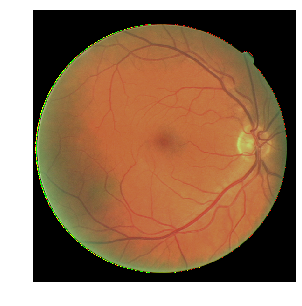

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))
src_size = np.array(img.shape[1:])

In [9]:
get_y_fn = lambda x: path_train_lbl/f'{x.parts[-1].split("_")[0]}_manual1.gif'

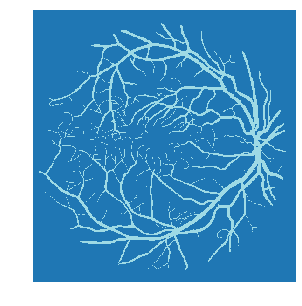

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

### Load the text labels for the label values

In [11]:
codes = np.loadtxt(path/'training/codes.txt', dtype=str); codes

array(['Background', 'Artery'], dtype='<U10')

In [12]:
tfms = get_transforms(flip_vert=True, max_rotate=12.5, max_zoom=1.10, max_lighting=0.15, max_warp=0., p_affine=0.0, p_lighting=0.6, xtra_tfms=[contrast(scale=(2, 2))])

## Evaluation metric

In [13]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = 9

def dice(pred, target):
    smooth = 1.
   
    # have to use contiguous since they may from a torch.view op
    iflat = pred.argmax(dim=1).contiguous().view(pred.shape[0], -1)
    tflat = target.squeeze(dim=1).contiguous().view(target.shape[0], -1)
    
    intersection = torch.sum(iflat * tflat, dim=1, dtype=torch.float)
    union = torch.sum(tflat + iflat, dim=1, dtype=torch.float)
    
    return ((2. * intersection) / (union + smooth)).mean()

## Create datasets

In [14]:
src = (SegmentationItemList.from_folder(path_train_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [15]:
size = src_size//2
bs=2
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

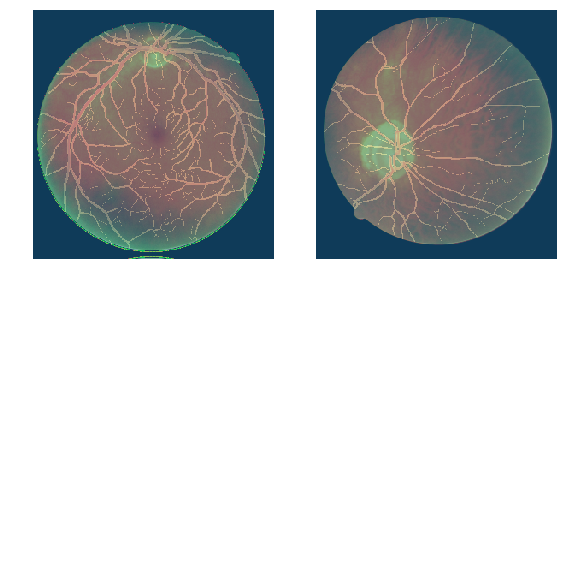

In [16]:
data.show_batch(bs, ds_type=DatasetType.Train)

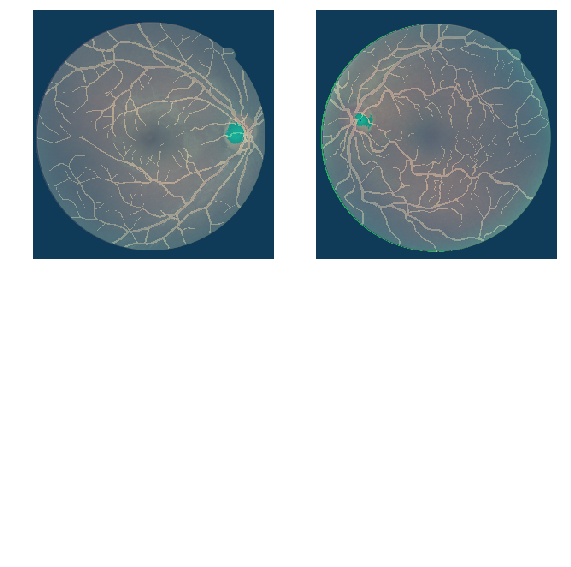

In [17]:
data.show_batch(bs, ds_type=DatasetType.Valid)

## Create U-Net Model

In [18]:
metrics=dice
wd=1e-3
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


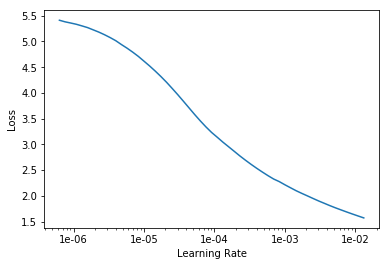

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
lr=1e-3

In [21]:
learn.fit_one_cycle(15, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice
1,1.814784,0.416522,0.000000
2,1.058357,0.300501,0.000000
3,0.762575,0.290995,0.000000
4,0.608438,0.259936,0.000000
5,0.511148,0.244466,0.004670
6,0.443191,0.241474,0.000140
7,0.388423,0.225339,0.098697
8,0.347894,0.183917,0.268076
9,0.315838,0.174504,0.593600
10,0.286805,0.153867,0.533042


In [22]:
learn.save('stage-1-18')

In [ ]:
learn.load('stage-1-50');

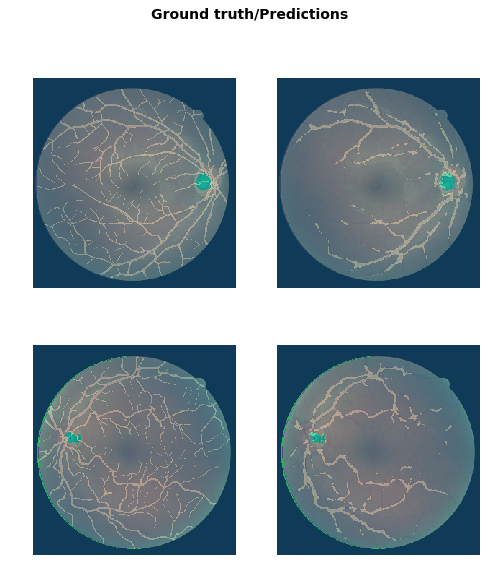

In [25]:
learn.show_results(rows=3, figsize=(8,9))

In [23]:
learn.unfreeze()

In [24]:
lrs = slice(lr/1000,lr/10)

In [25]:
learn.fit_one_cycle(25, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice
1,0.128019,0.135454,0.685006
2,0.127483,0.136174,0.690311
3,0.126828,0.134206,0.688103
4,0.126280,0.132434,0.688587
5,0.126193,0.132223,0.692408
6,0.125979,0.130943,0.690446
7,0.125408,0.131343,0.692259
8,0.124856,0.132336,0.695737
9,0.124312,0.127977,0.690367
10,0.123699,0.125344,0.690535


In [26]:
learn.save('stage-2-18')

## Train a model on the original image size

In [27]:
src = (SegmentationItemList.from_folder(path_train_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [28]:
bs=2
data = (src.transform(tfms, size=src_size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [29]:
metrics=dice
wd=1e-3
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd).to_fp16()

In [30]:
learn.load('stage-2-18')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (16 items)
[ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images
x: SegmentationItemList (16 items)
[Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images;

Valid: LabelList
y: SegmentationLabelList (4 items)
[ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images
x: SegmentationItemList (4 items)
[Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2),

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


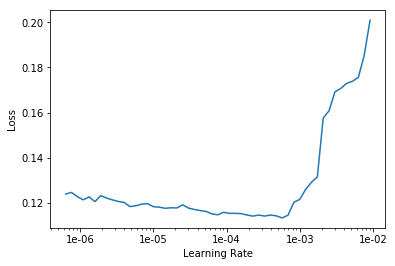

In [31]:
lr_find(learn)
learn.recorder.plot()

In [32]:
lr=1e-4

In [33]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice
1,0.118419,0.115900,0.736732
2,0.115723,0.114267,0.756409
3,0.113139,0.112075,0.756901
4,0.110831,0.108313,0.766627
5,0.108718,0.119213,0.764401
6,0.106857,0.099938,0.769344
7,0.105370,0.107587,0.777494
8,0.104303,0.098827,0.772877
9,0.102781,0.111695,0.766519
10,0.101424,0.101784,0.773224


In [34]:
learn.save('stage-1-18-big')

In [17]:
learn.load('stage-1-18-big')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (19 items)
[ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images
x: SegmentationItemList (19 items)
[Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images;

Valid: LabelList
y: SegmentationLabelList (1 items)
[ImageSegment (1, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images
x: SegmentationItemList (1 items)
[Image (3, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
  

In [35]:
learn.unfreeze()

In [42]:
lrs = slice(lr/10000,lr/100)

In [43]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,dice
1,0.082638,0.096950,0.790275
2,0.082427,0.096633,0.790068
3,0.082232,0.097707,0.789893
4,0.082098,0.096719,0.790471
5,0.082113,0.095894,0.790329
6,0.082432,0.095740,0.790687
7,0.082217,0.095784,0.790622
8,0.082221,0.096151,0.790705
9,0.082142,0.096679,0.789964
10,0.082247,0.096423,0.790642


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


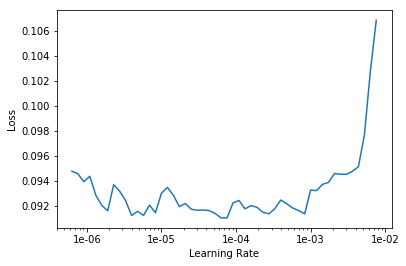

In [46]:
lr_find(learn)
learn.recorder.plot()

In [44]:
learn.save('stage-2-18-big')

## Create test predictions

In [45]:
metrics=dice
wd=1e-3
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)

In [46]:
learn.load('stage-2-18-big')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (16 items)
[ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images
x: SegmentationItemList (16 items)
[Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images;

Valid: LabelList
y: SegmentationLabelList (4 items)
[ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564), ImageSegment (1, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images
x: SegmentationItemList (4 items)
[Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564), Image (3, 584, 564)]...
Path: /home/sanne/Data/drive/data/training/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2),

In [47]:
for file_name in path_test_img.ls():
    print(file_name)
    idx = int(file_name.name[-11:-9])
    img = open_image(file_name)
    predict = learn.predict(contrast(img, scale=2))
    data = predict[1].transpose(0,2).transpose(0,1)
    out_file = path_test_pred/("{}.png".format(idx))
    imageio.imwrite(out_file.as_posix(), data.numpy())    

/home/sanne/Data/drive/data/test/images/05_test.tif


/home/sanne/Data/drive/data/test/images/08_test.tif


/home/sanne/Data/drive/data/test/images/13_test.tif


/home/sanne/Data/drive/data/test/images/12_test.tif


/home/sanne/Data/drive/data/test/images/06_test.tif


/home/sanne/Data/drive/data/test/images/07_test.tif


/home/sanne/Data/drive/data/test/images/14_test.tif


/home/sanne/Data/drive/data/test/images/09_test.tif


/home/sanne/Data/drive/data/test/images/01_test.tif


/home/sanne/Data/drive/data/test/images/15_test.tif


/home/sanne/Data/drive/data/test/images/16_test.tif


/home/sanne/Data/drive/data/test/images/18_test.tif


/home/sanne/Data/drive/data/test/images/10_test.tif


/home/sanne/Data/drive/data/test/images/20_test.tif


/home/sanne/Data/drive/data/test/images/19_test.tif


/home/sanne/Data/drive/data/test/images/02_test.tif


/home/sanne/Data/drive/data/test/images/04_test.tif


/home/sanne/Data/drive/data/test/images/17_test.tif


/home/sanne/Data/drive/data/test/images/03_test.tif


/home/sanne/Data/drive/data/test/images/11_test.tif


In [48]:
for file_name in path_test_pred.ls():
    undo_crop(file_name)
    decode_label(file_name)

In [45]:
! zip -j submit.zip {path_test_pred}/*

  adding: 1.png (deflated 1%)
  adding: 10.png (deflated 1%)
  adding: 11.png (deflated 1%)
  adding: 12.png (deflated 1%)
  adding: 13.png (deflated 1%)
  adding: 14.png (deflated 1%)
  adding: 15.png (deflated 1%)
  adding: 16.png (deflated 1%)
  adding: 17.png (deflated 1%)
  adding: 18.png (deflated 1%)
  adding: 19.png (deflated 1%)
  adding: 2.png (deflated 1%)
  adding: 20.png (deflated 1%)
  adding: 3.png (deflated 1%)
  adding: 4.png (deflated 1%)
  adding: 5.png (deflated 1%)
  adding: 6.png (deflated 1%)
  adding: 7.png (deflated 1%)
  adding: 8.png (deflated 1%)
  adding: 9.png (deflated 1%)


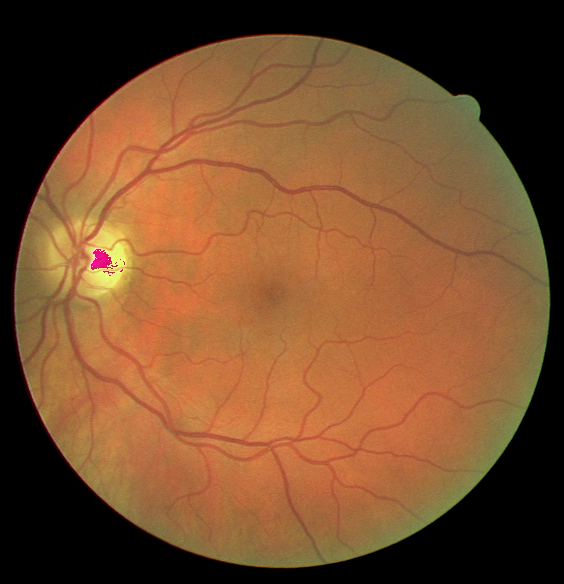

In [48]:
img